# Draft_01_v4

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Cátia Brás (), Ricardo Kayseller (95813)

# 1. Introduction

Generative Adversarial Networks (GANs) have become a fundamental class of generative models for learning complex data distributions and synthesizing realistic samples. In the classical (unconditional) GAN framework, the generator receives only random noise as input and learns to produce samples that resemble the training data, while the discriminator learns to distinguish real data from generated samples. Although this setting allows the model to generate realistic images, it provides no control over the semantic content of the generated samples. In the context of datasets with labeled structure, such as MNIST, an unconditional GAN may generate any digit between 0 and 9, but the user cannot specify which digit should be produced.

Conditional Generative Adversarial Networks (cGANs) extend the original GAN formulation by incorporating additional side information, such as class labels, into both the generator and the discriminator. By conditioning the generation process on a label 𝑦, the generator learns a mapping 𝐺(𝑧,𝑦) that aims to produce samples consistent with the desired class, while the discriminator is trained to assess not only whether an image is real or fake, but also whether it matches the provided condition. This conditioning mechanism enables controlled generation and significantly increases the practical usefulness of GANs in applications where semantic attributes matter, such as digit synthesis, object class control, and, more generally, text-to-image generation.

In this project, we investigate the implementation and behavior of conditional GANs on the MNIST dataset of handwritten digits. Starting from an unconditional DCGAN baseline, we progressively introduce conditioning mechanisms that allow explicit control over the generated digit class. Beyond basic conditioning via concatenation of labels, we explore stabilization strategies inspired by the literature, such as Spectral Normalization applied to the discriminator, in order to mitigate training instabilities and mode collapse. The experimental analysis focuses on both qualitative and quantitative aspects, including visual inspection of generated samples, class-conditional control checks, intra-class diversity, and discriminator behavior during training.

The main objective of this work is to demonstrate that conditional adversarial training enables controllable image generation, to analyze the limitations of simple conditioning strategies, and to assess how architectural and training refinements improve stability, diversity, and label consistency. This study provides practical insights into the challenges of training cGANs and highlights the importance of appropriate conditioning and regularization techniques for achieving reliable class-conditional generation.

## 1.1 Environment Setup

---

In [1]:
# Import required dependencies
import os
import time
import numpy as np
from copy import deepcopy
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torch.nn.utils import spectral_norm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

## 1.2 Global Configuration and Training Hyperparameters

In [2]:
# Global variables

SEED = 42

LIVE_MONITOR = True
EMIT_INTERVAL = 1

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

NUM_STEPS = 15005
SAVE_INTERVAL = 1000

# Loss function strategy: "bce", "lsgan", "hinge", "wgan-gp"
LOSS_STRATEGY = "wgan-gp"

# TTUR: Two Time-Scale Update Rule
# D learns faster than G, so we use different learning rates
LR_D = 4e-4  # Discriminator learning rate
LR_G = 1e-4  # Generator learning rate (4x slower)

# Adam betas optimized for GAN training
# Lower β1 (0.5 vs default 0.9) reduces momentum, stabilizes adversarial updates
ADAM_BETAS = (0.5, 0.999)

# Label smoothing for BCE/LSGAN (use 0.9 instead of 1.0 for real labels)
LABEL_SMOOTHING_REAL = 0.9

# WGAN-GP: number of critic steps per generator step
N_CRITIC = 5

MODEL_OUTPUT_PATH = "model/"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

NUM_EVAL_SAMPLES = 10000

# Strategies to benchmark
BENCHMARK_STRATEGIES = ["bce", "lsgan", "hinge", "wgan-gp"]

### 1.2.1 Setup and Training Strategy

This project adopts a systematic experimental design to analyze the behavior and stability of conditional Generative Adversarial Networks (cGANs) on the MNIST dataset. Beyond implementing a single adversarial formulation, multiple loss strategies are benchmarked, including the standard binary cross-entropy (BCE) loss, Least Squares GAN (LSGAN), hinge loss, and Wasserstein GAN with Gradient Penalty (WGAN-GP). This design choice follows the theoretical and empirical insights discussed in the lecture materials on GAN losses and training stability, which highlight that different adversarial objectives lead to substantially different optimization dynamics, convergence behavior, and robustness to mode collapse. In particular, WGAN-GP is included due to its smoother loss landscape and explicit enforcement of the Lipschitz constraint, which is known to improve training stability compared to classical GAN formulations.

Training is performed using the Two Time-Scale Update Rule (TTUR), where the discriminator is updated with a learning rate four times higher than the generator (LR_D = 4×10⁻⁴, LR_G = 1×10⁻⁴). This choice is directly motivated by best practices discussed in the GAN training “recipe” guidelines, which emphasize that an overly weak discriminator fails to provide informative gradients to the generator, while an overly strong discriminator can lead to vanishing gradients. The Adam optimizer is used with β₁ = 0.5 and β₂ = 0.999, following the DCGAN and subsequent GAN literature, as these hyperparameters are empirically known to stabilize adversarial training by reducing excessive momentum in the discriminator updates.

The batch size is set to 128, representing a compromise between training stability and computational efficiency. Larger batch sizes generally provide more stable gradient estimates for both generator and discriminator, while still fitting comfortably within GPU memory constraints. The dimensionality of the latent space is fixed to 100, following common practice in DCGAN-style architectures, which provides sufficient capacity for modeling the variability of handwritten digits without introducing unnecessary complexity.

Training is defined in terms of a fixed number of optimization steps rather than epochs. Specifically, the model is trained for 15,005 steps. This value originates from the reference Keras implementation that was converted to PyTorch and corresponds approximately to 32 epochs over the MNIST training set (MNIST contains 60,000 samples, and with a batch size of 128, one epoch corresponds to roughly 469 iterations). The step-based formulation is consistent with how GAN experiments are typically reported in the literature, as it provides finer control over the balance between generator and discriminator updates, enables predictable checkpointing and sampling intervals, and facilitates fair comparisons across different training configurations. The additional offset of five steps ensures that the final checkpoint aligns exactly with the predefined sampling interval of 1,000 steps, allowing the evolution of generated samples to be consistently monitored at fixed milestones throughout training.

### 1.2.2 Live Training Monitor for GAN Benchmarking (Real-Time Dashboard)

In [3]:
if LIVE_MONITOR:
    from bin.gan_monitor import (
        start_server, emit_frames, emit_done,
        emit_benchmark_start, emit_strategy_start, emit_strategy_end
    )
    start_server(port=8992)

[gan_monitor] Live monitor at http://localhost:8992


A real-time monitoring dashboard was integrated into the training pipeline to support continuous inspection of adversarial dynamics during benchmarking. When enabled, a lightweight local server streams training diagnostics such as generator sample grids, discriminator and generator loss trajectories, and per-strategy progress markers. This design aligns with best-practice recommendations for GAN training, where losses alone are often insufficient to assess convergence or detect failure modes. The live monitor improves experimental transparency, facilitates early detection of mode collapse or imbalance between networks, and ensures consistent reporting across multiple loss strategies within the same benchmarking framework.  


In [4]:
# Set random seeds for reproducibility across both numpy and pytorch
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. Modular GAN Loss Strategies (BCE, LSGAN, Hinge, WGAN-GP)

In [6]:
# Loss Strategies

class GANLossStrategy(ABC):
    """Base class for GAN loss strategies."""
    use_sigmoid: bool = True
    use_label_smoothing: bool = False  # only BCE/LSGAN use this
    n_critic: int = 1  # D steps per G step
    smooth_real: float = 1.0
    
    @abstractmethod
    def d_loss_real(self, output: Tensor) -> Tensor:
        """Discriminator loss for real images."""
        pass
    
    @abstractmethod
    def d_loss_fake(self, output: Tensor) -> Tensor:
        """Discriminator loss for fake images."""
        pass
    
    @abstractmethod
    def g_loss(self, output: Tensor) -> Tensor:
        """Generator loss."""
        pass
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        """Gradient penalty (only used by WGAN-GP)."""
        return torch.tensor(0.0, device=real_imgs.device)
    
    def set_d_model(self, d_model) -> None:
        """Set discriminator reference (used by WGAN-GP)."""
        pass
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """Combine D losses. Override for strategy-specific formulas."""
        return 0.5 * (d_loss_real + d_loss_fake) + gp


class BCELossStrategy(GANLossStrategy):
    """Binary Cross-Entropy loss (original GAN) with label smoothing."""
    use_sigmoid = True
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.BCELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        # G wants D to output 1.0 (no smoothing for G)
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class LSGANLossStrategy(GANLossStrategy):
    """Least Squares loss with label smoothing."""
    use_sigmoid = False
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.MSELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class HingeLossStrategy(GANLossStrategy):
    """Hinge loss — used in SAGAN, BigGAN."""
    use_sigmoid = False
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 - output))
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 + output))
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)


class WGANGPLossStrategy(GANLossStrategy):
    """Wasserstein loss with gradient penalty."""
    use_sigmoid = False
    n_critic = 5  # train D 5 times per G step
    
    def __init__(self, lambda_gp: float = 10.0):
        self.d_model = None
        self.lambda_gp = lambda_gp
    
    def set_d_model(self, d_model) -> None:
        self.d_model = d_model
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(output)
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        if self.d_model is None:
            raise RuntimeError("d_model not set. Call set_d_model() first.")
        
        batch_size = real_imgs.size(0)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=real_imgs.device)
        interpolated = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        
        d_out = self.d_model(interpolated, labels)
        
        gradients = torch.autograd.grad(
            outputs=d_out,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_out),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        return self.lambda_gp * ((gradient_norm - 1) ** 2).mean()
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """WGAN-GP uses d_fake - d_real + gp (no 0.5 averaging)."""
        return d_loss_fake + d_loss_real + gp  # note: d_loss_real is already negated


def get_loss_strategy(name: str, device) -> GANLossStrategy:
    """Factory function to get loss strategy by name."""
    strategies = {
        "bce": BCELossStrategy,
        "lsgan": LSGANLossStrategy,
        "hinge": HingeLossStrategy,
        "wgan-gp": WGANGPLossStrategy,
    }
    if name not in strategies:
        raise ValueError(f"Unknown loss strategy: {name}. Options: {list(strategies.keys())}")
    
    if name == "bce":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    if name == "lsgan":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    return strategies[name]()

#### 2.1 GAN Loss Strategies and Benchmarking Framework

In order to systematically study the impact of different adversarial objectives on training stability and sample quality, the training pipeline was designed around a modular loss-strategy framework. Instead of hard-coding a single GAN loss, a common abstract interface was defined to encapsulate the discriminator and generator loss components, enabling multiple loss formulations to be benchmarked under identical architectural and optimization conditions.

Four widely adopted loss strategies were implemented and evaluated:

1. **Binary Cross-Entropy (BCE) Loss**  
   This strategy corresponds to the original GAN formulation, where the discriminator is trained as a probabilistic classifier distinguishing real from generated samples. The generator is optimized to maximize the probability that fake samples are classified as real. To improve training stability, label smoothing is applied to real samples, reducing overconfidence in the discriminator and mitigating sharp gradients that may destabilize the adversarial dynamics. This formulation directly reflects the classical minimax game described in the original GAN literature.

2. **Least Squares GAN (LSGAN)**  
   The LSGAN objective replaces the binary cross-entropy loss with a least-squares regression loss. Instead of learning to output hard binary decisions, the discriminator is encouraged to regress towards continuous target values for real and fake samples. This formulation has been shown to reduce vanishing gradients and produce smoother optimization landscapes, often resulting in more stable convergence during training. As in the BCE strategy, label smoothing is applied to the real targets to further regularize the discriminator.

3. **Hinge Loss**  
   The hinge loss formulation adopts a margin-based objective, where the discriminator enforces a separation between real and fake samples using a hinge function. Rather than predicting explicit probabilities, the discriminator outputs real-valued scores, and the generator is trained to maximize these scores for generated samples. This loss is commonly used in modern high-performance GAN architectures and aligns with the design patterns discussed in contemporary GAN literature, particularly in combination with architectural constraints such as spectral normalization.

4. **Wasserstein GAN with Gradient Penalty (WGAN-GP)**  
   The WGAN-GP strategy reformulates the adversarial game in terms of the Wasserstein distance between the real and generated data distributions. Instead of a classifier, the discriminator acts as a critic that assigns scalar scores to samples. To enforce the required Lipschitz continuity constraint, a gradient penalty term is added, penalizing deviations of the gradient norm from unity along linear interpolations between real and fake samples. Additionally, the critic is updated multiple times per generator update, following the two time-scale update principle, to ensure a sufficiently strong approximation of the Wasserstein distance during training.

By implementing these loss strategies within a unified interface, the project enables a fair and controlled comparison of fundamentally different adversarial objectives. All strategies share the same generator and discriminator architectures, optimization settings, and training schedule, ensuring that observed differences in convergence behavior, stability, and sample quality can be attributed primarily to the choice of loss function rather than to confounding implementation details. This benchmarking setup reflects the theoretical and practical considerations emphasized in the course materials, where the choice of adversarial loss is a central factor in the stability and effectiveness of GAN training.


## 3. Data Loading

---

In [7]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


### 3.1 Data Loading and Preprocessing (MNIST → Tensor → Normalized to [-1, 1])

MNIST images were converted to tensors and normalized to the range [-1, 1] using a mean of 0.5 and standard deviation of 0.5. This preprocessing step is required when the generator outputs images through a Tanh activation, ensuring that real and generated samples lie on the same numerical scale. The training split contains 60,000 images, and batching was performed with shuffling enabled. The DataLoader used drop_last=True to maintain a constant batch size across iterations, simplifying adversarial training dynamics and logging.


## 4. Generator and Discriminator

---

### 4.1 Conditional Generator (PixelShuffle Upsampling + ICNR Initialization)


In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
        )

        # Block 1: 7x7 -> 14x14
        self.conv1 = nn.Conv2d(128, 128 * 4, kernel_size=3, padding=1)
        self.ps1 = nn.PixelShuffle(2)
        self.bn1 = nn.BatchNorm2d(128, momentum=0.8)

        # Block 2: 14x14 -> 28x28
        self.conv2 = nn.Conv2d(128, 64 * 4, kernel_size=3, padding=1)
        self.ps2 = nn.PixelShuffle(2)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.8)

        self.output_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.apply(self._init_weights)
        self._icnr_init(self.conv1, upscale_factor=2)
        self._icnr_init(self.conv2, upscale_factor=2)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def _icnr_init(self, conv_layer, upscale_factor):
        """Specialized initialization to prevent checkerboard/dots."""
        new_shape = [
            conv_layer.out_channels // (upscale_factor**2),
            conv_layer.in_channels,
            conv_layer.kernel_size[0],
            conv_layer.kernel_size[1]
        ]
        sub_kernel = torch.randn(new_shape) * 0.02
        # Repeat the sub-kernel across the 'sub-pixel' channels
        # This makes all 4 pixels in a 2x2 block start identical
        icnr_kernel = sub_kernel.repeat_interleave(upscale_factor**2, dim=0)
        conv_layer.weight.data.copy_(icnr_kernel)

    def forward(self, z, labels):
        label_embed = self.label_embedding(labels).squeeze(1)
        x = self.fc(z * label_embed)
        x = x.view(-1, 128, 7, 7)

        x = F.relu(self.bn1(self.ps1(self.conv1(x))))
        x = F.relu(self.bn2(self.ps2(self.conv2(x))))
        return torch.tanh(self.output_conv(x))


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (conv1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps1): PixelShuffle(upscale_factor=2)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps2): PixelShuffle(upscale_factor=2)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (output_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


The conditional generator was implemented using a PixelShuffle-based upsampling architecture. Class conditioning was introduced through a learned embedding of the digit label into the latent space, combined multiplicatively with the noise vector to modulate the generation process. The model first projects the conditioned latent code into a 7×7×128 feature map, then performs two stages of sub-pixel upsampling (7→14→28) using convolution + PixelShuffle blocks with Batch Normalization and ReLU activations. To reduce checkerboard and dot artifacts that can emerge from upsampling, ICNR initialization was applied to the convolutional layers preceding PixelShuffle. Finally, the generator outputs a 28×28 grayscale image through a Tanh activation, which is consistent with preprocessing that normalizes MNIST images to the range [-1, 1].


### 4.2 Conditional Discriminator (Label Map Concatenation + Spectral Normalization)


In [9]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES, use_sigmoid=True):
        super().__init__()
        
        self.use_sigmoid = use_sigmoid

        # Embed the class label into a vector of size 28*28
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network with Spectral Normalization
        self.model = nn.Sequential(
            # Input is (2, 28, 28): image channel + label channel
            spectral_norm(nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten
            nn.Flatten(),

            # Dense layers with Spectral Normalization
            spectral_norm(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
            nn.Dropout(0.25),

            spectral_norm(nn.Linear(512, 1)),
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        
        # Embed label and reshape to spatial map
        label_embed = self.label_embedding(labels)
        label_embed = label_embed.view(batch_size, 1, 28, 28)

        # Concatenate image and label map
        x = torch.cat([img, label_embed], dim=1)

        x = self.model(x)
        
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        
        return x

The conditional discriminator was implemented using a label-map concatenation strategy, where each class label was embedded into a 28×28 spatial map and concatenated with the input image as an additional channel. The architecture consisted of two spectral-normalized convolutional blocks that progressively downsampled the input (28→14→7), followed by a spectral-normalized multilayer perceptron that produced a single authenticity score. Spectral normalization was applied to stabilize adversarial training by constraining the discriminator’s sensitivity, reducing oscillations and improving robustness to mode collapse. For benchmarking across different adversarial objectives (BCE, LSGAN, hinge, and WGAN-GP), the discriminator was configured to output raw scores (logits), allowing each loss strategy to apply its appropriate formulation without relying on a fixed sigmoid output.


### 4.3 Weight Initialization (DCGAN-Style + Safe Handling for Spectral Normalization)

In [10]:
def weights_init(m):
    """
    DCGAN-style weight initialization.
    Skip spectral_norm wrapped layers (they handle their own init).
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and not hasattr(m, 'weight_orig'):
        # Conv layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1 and not hasattr(m, 'weight_orig'):
        # Linear layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

Model parameters were initialized following the DCGAN guidelines, which recommend sampling convolutional and fully connected weights from a Normal(0, 0.02) distribution and initializing batch normalization layers with weights drawn from Normal(1, 0.02) and zero bias. This initialization scheme has been shown to promote stable adversarial dynamics during the early stages of training and to reduce the likelihood of vanishing gradients or premature mode collapse.

Label embedding layers were initialized using the same Normal(0, 0.02) distribution to ensure comparable scale between latent and conditional representations. For layers wrapped with Spectral Normalization, initialization was applied to the underlying unnormalized weight parameters (weight_orig) rather than the normalized weights, ensuring consistent parameter scaling at initialization while preserving the Lipschitz constraint enforced during training. This design choice aligns with best practices in stabilizing GAN training, as discussed in the DCGAN and SNGAN literature, where careful weight initialization and spectral normalization jointly contribute to improved convergence behavior and reduced training oscillations.

# 5. Loss and Optimizers

---

### 5.1 Model Instantiation, Loss Strategy Selection, and TTUR Optimizers


In [11]:
# Instantiate models
g_model = Generator().to(device)  # has its own init
d_model = Discriminator(use_sigmoid=(LOSS_STRATEGY == "bce")).to(device)

# Apply DCGAN weight initialization only to D
d_model.apply(weights_init)
print("Applied DCGAN weight initialization to Discriminator")

# Get loss strategy
loss_strategy = get_loss_strategy(LOSS_STRATEGY, device)
loss_strategy.set_d_model(d_model)
print(f"Using loss strategy: {LOSS_STRATEGY}")
print(f"  - use_sigmoid: {loss_strategy.use_sigmoid}")
print(f"  - n_critic: {loss_strategy.n_critic}")
if loss_strategy.use_label_smoothing:
    print(f"  - label_smoothing: {loss_strategy.smooth_real}")

# Optimizers with TTUR
optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=ADAM_BETAS)
optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=ADAM_BETAS)
print(f"TTUR: LR_D={LR_D}, LR_G={LR_G}, betas={ADAM_BETAS}")

Applied DCGAN weight initialization to Discriminator
Using loss strategy: wgan-gp
  - use_sigmoid: False
  - n_critic: 5
TTUR: LR_D=0.0004, LR_G=0.0001, betas=(0.5, 0.999)


Models were instantiated on the selected compute device, with the generator using its internal initialization (including ICNR initialization for PixelShuffle upsampling) and the discriminator initialized using DCGAN-style weight initialization to improve early training stability. A modular loss-strategy interface was used to select the adversarial objective (BCE, LSGAN, hinge, or WGAN-GP). For WGAN-GP, the discriminator instance was passed into the strategy object to enable computation of the gradient penalty term, enforcing the Lipschitz constraint required by the Wasserstein formulation. Training used the Two Time-Scale Update Rule (TTUR), configuring separate Adam optimizers for discriminator and generator with a higher discriminator learning rate (LR_D > LR_G) and GAN-optimized momentum parameters (β₁=0.5, β₂=0.999). This setup supports stable adversarial dynamics and enables fair benchmarking across different loss formulations under consistent optimization conditions.


# 6. Training

---

### 6.1 Benchmark Loop: Training Multiple GAN Losses with Real-Time Monitoring and Unified Evaluation


In [12]:
# Benchmark training loop

# Store results
benchmark_results = {}

def run_benchmark(strategies=BENCHMARK_STRATEGIES, num_steps=NUM_STEPS, save_interval=SAVE_INTERVAL):
    """
    Run training for each loss strategy and collect metrics.
    """
    results = {}
    
    # Emit benchmark start
    if LIVE_MONITOR:
        emit_benchmark_start(strategies, num_steps)
    
    for strategy_idx, strategy_name in enumerate(strategies):
        print(f"\n{'='*60}")
        print(f"TRAINING: {strategy_name.upper()}")
        print(f"{'='*60}\n")
        
        # Emit strategy start
        if LIVE_MONITOR:
            emit_strategy_start(strategy_name, strategy_idx, len(strategies))
        
        # Reset random seeds for fair comparison
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        
        # Instantiate fresh models
        g_model = Generator().to(device)
        d_model = Discriminator(use_sigmoid=(strategy_name == "bce")).to(device)
        d_model.apply(weights_init)
        
        # Get loss strategy
        loss_strategy = get_loss_strategy(strategy_name, device)
        loss_strategy.set_d_model(d_model)
        
        # Optimizers
        optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=ADAM_BETAS)
        optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=ADAM_BETAS)
        
        # Training state
        losses = {"G": [], "D": []}
        data_iter = iter(train_loader)
        n_critic = loss_strategy.n_critic
        d_loss = torch.tensor(0.0)
        
        # Fixed test samples for visualization
        samples_test = torch.randn(16, LATENT_DIM, device=device)
        labels_test = torch.randint(0, 10, (16, 1), device=device)
        
        # Timing
        start_time = time.time()
        
        for step in range(num_steps):
            # --- Train Discriminator ---
            for _ in range(n_critic):
                try:
                    real_imgs, batch_labels = next(data_iter)
                except StopIteration:
                    data_iter = iter(train_loader)
                    real_imgs, batch_labels = next(data_iter)

                real_imgs = real_imgs.to(device)
                batch_labels = batch_labels.unsqueeze(1).to(device)

                noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
                fake_imgs = g_model(noise, batch_labels)

                optimizer_d.zero_grad()
                d_real_out = d_model(real_imgs, batch_labels)
                d_loss_real = loss_strategy.d_loss_real(d_real_out)
                d_fake_out = d_model(fake_imgs.detach(), batch_labels)
                d_loss_fake = loss_strategy.d_loss_fake(d_fake_out)
                gp = loss_strategy.gradient_penalty(real_imgs, fake_imgs.detach(), batch_labels)
                d_loss = loss_strategy.compute_d_loss(d_loss_real, d_loss_fake, gp)
                d_loss.backward()
                optimizer_d.step()

            # --- Train Generator ---
            optimizer_g.zero_grad()
            z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
            gen_labels = torch.randint(0, 10, (BATCH_SIZE, 1), device=device)
            gen_imgs = g_model(z, gen_labels)
            g_out = d_model(gen_imgs, gen_labels)
            g_loss = loss_strategy.g_loss(g_out)
            g_loss.backward()
            optimizer_g.step()

            losses["G"].append(g_loss.item())
            losses["D"].append(d_loss.item())

            if step % save_interval == 0:
                print(f"Step {step} — D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")

            # Live monitor
            if LIVE_MONITOR and step % EMIT_INTERVAL == 0:
                with torch.no_grad():
                    monitor_samples = g_model(samples_test, labels_test)
                emit_frames(monitor_samples, labels_test, step, g_loss.item(), d_loss.item(), num_steps)
        
        training_time = time.time() - start_time
        
        # Evaluate
        print(f"\nEvaluating {strategy_name}...")
        fid_score, kid_mean, kid_std = evaluate_model_for_benchmark(g_model)
        
        # Emit strategy end with results
        if LIVE_MONITOR:
            emit_strategy_end(strategy_name, fid_score, kid_mean, kid_std, training_time)
        
        # Generate final samples
        with torch.no_grad():
            final_samples = g_model(samples_test, labels_test)
        
        # Store results
        results[strategy_name] = {
            "losses": losses,
            "fid": fid_score,
            "kid_mean": kid_mean,
            "kid_std": kid_std,
            "training_time": training_time,
            "g_model_state": deepcopy(g_model.state_dict()),
            "d_model_state": deepcopy(d_model.state_dict()),
            "final_samples": final_samples.cpu(),
            "labels_test": labels_test.cpu(),
        }
        
        print(f"\n{strategy_name.upper()} Results:")
        print(f"  FID: {fid_score:.2f}")
        print(f"  KID: {kid_mean:.4f} ± {kid_std:.4f}")
        print(f"  Time: {training_time:.1f}s")
    
    # Emit benchmark complete
    if LIVE_MONITOR:
        emit_done()
    
    return results


def evaluate_model_for_benchmark(g_model):
    """Evaluation function for benchmarking (returns values, doesn't print)."""
    fid = FrechetInceptionDistance(feature=2048).to(device)
    kid = KernelInceptionDistance(feature=2048, subset_size=100).to(device)

    idx = np.random.randint(0, len(train_dataset), NUM_EVAL_SAMPLES)
    batch_size = 256
    
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        batch_idx = idx[i:i + batch_size]
        real_batch = torch.stack([train_dataset[j][0] for j in batch_idx])
        real_batch = ((real_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        real_batch = real_batch.repeat(1, 3, 1, 1)
        real_batch = torch.nn.functional.interpolate(
            real_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        current_batch = min(batch_size, NUM_EVAL_SAMPLES - i)
        noise = torch.randn(current_batch, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (current_batch, 1), device=device)
        with torch.no_grad():
            fake_batch = g_model(noise, labels)
        fake_batch = ((fake_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        fake_batch = torch.nn.functional.interpolate(
            fake_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(fake_batch, real=False)
        kid.update(fake_batch, real=False)

    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()
    
    return fid_score, kid_mean.item(), kid_std.item()


# Run the benchmark
benchmark_results = run_benchmark()

[gan_monitor] Benchmark started: ['bce', 'lsgan', 'hinge', 'wgan-gp']

TRAINING: BCE

[gan_monitor] Strategy started: bce (1/4)
Step 0 — D: 0.7372, G: 0.5647
Step 1000 — D: 0.6051, G: 0.9763
Step 2000 — D: 0.6596, G: 0.8842
Step 3000 — D: 0.6718, G: 0.8373
[gan_monitor] Client connected: I4SEKFgmjGGrnMwwAAAB
Step 4000 — D: 0.6727, G: 0.8163
Step 5000 — D: 0.6777, G: 0.8352
Step 6000 — D: 0.6793, G: 0.8129
Step 7000 — D: 0.6832, G: 0.8114
Step 8000 — D: 0.6849, G: 0.8117
Step 9000 — D: 0.6849, G: 0.8172
Step 10000 — D: 0.6800, G: 0.8072
Step 11000 — D: 0.6813, G: 0.8261
Step 12000 — D: 0.6836, G: 0.8169
Step 13000 — D: 0.6817, G: 0.8065
Step 14000 — D: 0.6813, G: 0.7805
Step 15000 — D: 0.6792, G: 0.7872

Evaluating bce...


/home/ricarl/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


[gan_monitor] Strategy complete: bce (FID: 7.64)

BCE Results:
  FID: 7.64
  KID: 0.0046 ± 0.0021
  Time: 303.7s

TRAINING: LSGAN

[gan_monitor] Strategy started: lsgan (2/4)
Step 0 — D: 0.6506, G: 0.1799
Step 1000 — D: 0.0992, G: 0.5783
Step 2000 — D: 0.1590, G: 0.4363
Step 3000 — D: 0.1821, G: 0.3880
Step 4000 — D: 0.1899, G: 0.3408
Step 5000 — D: 0.1865, G: 0.3319
Step 6000 — D: 0.1953, G: 0.3320
Step 7000 — D: 0.1956, G: 0.3132
Step 8000 — D: 0.1941, G: 0.3257
Step 9000 — D: 0.1920, G: 0.3155
Step 10000 — D: 0.1902, G: 0.3134
Step 11000 — D: 0.1986, G: 0.3128
Step 12000 — D: 0.1982, G: 0.3291
Step 13000 — D: 0.1921, G: 0.3221
Step 14000 — D: 0.1950, G: 0.3185
Step 15000 — D: 0.1879, G: 0.3130

Evaluating lsgan...
[gan_monitor] Strategy complete: lsgan (FID: 7.59)

LSGAN Results:
  FID: 7.59
  KID: 0.0041 ± 0.0021
  Time: 287.7s

TRAINING: HINGE

[gan_monitor] Strategy started: hinge (3/4)
Step 0 — D: 1.1010, G: -0.3082
Step 1000 — D: 0.7861, G: 0.2464
Step 2000 — D: 0.8995, G: 0.33

This section analyzes the empirical behavior of different adversarial loss functions—Binary Cross-Entropy (BCE), Least Squares GAN (LSGAN), Hinge loss, and Wasserstein GAN with Gradient Penalty (WGAN-GP)—under a controlled experimental protocol. All models were trained using the same architecture, initialization scheme, optimizer configuration (TTUR), batch size, and number of training steps, ensuring that observed differences can be attributed primarily to the choice of loss function rather than to confounding implementation factors.

#### 6.1.1 Training Dynamics and Stability

The different loss formulations exhibited markedly distinct training dynamics. The BCE and LSGAN objectives led to relatively smooth and stable loss trajectories, with both the discriminator and generator losses evolving gradually over training. This behavior is consistent with the theoretical motivation behind LSGAN, which replaces the binary cross-entropy objective with a least-squares formulation to reduce vanishing gradients and provide more informative error signals to the generator. In practice, this translated into more stable adversarial interactions and reduced oscillatory behavior when compared to the original GAN objective.

The Hinge loss, commonly used in large-scale GANs such as SAGAN and BigGAN, demonstrated more volatile loss patterns. While hinge-based training is known to encourage sharper decision boundaries and stronger discriminators, this increased discriminative pressure can lead to less stable generator updates in smaller-scale settings such as MNIST. This observation aligns with findings in the literature indicating that hinge loss often benefits from larger models, stronger regularization, and large-scale datasets, whereas in low-resolution domains it may induce higher variance in adversarial gradients.

WGAN-GP displayed substantially different numerical loss behavior, as expected from its theoretical formulation. Unlike BCE or LSGAN, the Wasserstein objective does not aim to directly approximate classification probabilities but instead optimizes an estimate of the Earth-Mover (Wasserstein-1) distance between real and generated data distributions. Consequently, discriminator (critic) losses were not directly comparable in magnitude to those observed for other strategies. The need for multiple critic updates per generator step and the computation of gradient penalties significantly increased computational cost. While WGAN-GP is theoretically well-motivated and often yields strong stability properties in high-dimensional image domains, in this experimental setting it introduced a heavier optimization burden without a proportional improvement in sample quality.

#### 6.1.2 Sample Quality and Distributional Fidelity

Qualitative inspection of generated samples across training revealed noticeable differences in convergence behavior. Models trained with BCE and LSGAN exhibited faster emergence of recognizable digit structures and more consistent class-conditional patterns over time. LSGAN, in particular, showed reduced artifacts and smoother digit contours, consistent with its design objective of penalizing samples proportionally to their distance from the decision boundary rather than using a saturating probabilistic loss.

Hinge loss models produced samples with sharper strokes in some cases but also exhibited greater variability in digit morphology, suggesting a trade-off between sharpness and stability. This behavior reflects the hinge objective’s emphasis on margin-based discrimination, which can amplify discriminator gradients when samples lie near the decision boundary.

WGAN-GP produced visually coherent samples but required substantially longer training times and careful tuning of hyperparameters (e.g., learning rates and gradient penalty weight) to avoid training instabilities. The increased computational overhead associated with gradient penalty computation and multiple critic updates limited its practical efficiency in this setting.

#### 6.1.3 Quantitative Evaluation and Comparative Trends

Quantitative evaluation using distributional similarity metrics provided a complementary perspective on model performance. Although such metrics are imperfect proxies for perceptual quality—particularly on datasets such as MNIST that differ significantly from the ImageNet domain on which Inception-based metrics are calibrated—they enable relative comparisons under identical conditions. Across loss strategies, BCE and LSGAN achieved consistently competitive performance, with LSGAN showing a slight advantage in terms of distributional alignment. Hinge loss lagged behind these two approaches, reflecting its less stable convergence in this low-resolution setting. WGAN-GP underperformed relative to the other strategies despite its stronger theoretical foundations, suggesting that its benefits may not fully materialize in small-scale or low-complexity domains.

#### 6.1.4 Discussion and Practical Implications

The comparative analysis highlights that, in the context of conditional MNIST generation with moderate model capacity, simpler adversarial objectives such as BCE and LSGAN can outperform more complex formulations. LSGAN, in particular, offers a favorable trade-off between training stability, computational efficiency, and sample quality, making it a strong baseline choice for conditional image generation in low-resolution settings. Hinge loss, while powerful in large-scale GANs, appears more sensitive to architectural and dataset scale, and may require additional regularization or capacity to fully leverage its advantages. WGAN-GP, despite its appealing theoretical guarantees, incurs substantial computational cost and optimization complexity, which may outweigh its benefits in smaller experimental setups.

These findings reinforce a broader theme in GAN research: more theoretically sophisticated objectives do not universally yield superior empirical performance, and the optimal loss function is highly dependent on dataset complexity, model capacity, and computational constraints. Consequently, careful empirical benchmarking remains essential when selecting adversarial objectives for a given application.


### 6.2 Benchmark Summary Table (FID/KID + Runtime) and Cross-Strategy Interpretation


In [13]:
# Results summary table

def print_results_table(results):
    """Print a formatted comparison table."""
    print("\n" + "="*70)
    print("BENCHMARK RESULTS SUMMARY")
    print("="*70)
    print(f"{'Strategy':<12} {'FID':>10} {'KID':>18} {'Time (s)':>12}")
    print("-"*70)
    
    # Sort by FID (best first)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['fid'])
    
    for i, (name, data) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        kid_str = f"{data['kid_mean']:.4f} ± {data['kid_std']:.4f}"
        print(f"{rank} {name:<10} {data['fid']:>10.2f} {kid_str:>18} {data['training_time']:>12.1f}")
    
    print("="*70)
    
    # Best performer
    best = sorted_results[0]
    print(f"\n✓ Best performer: {best[0].upper()} (FID: {best[1]['fid']:.2f})")

print_results_table(benchmark_results)


BENCHMARK RESULTS SUMMARY
Strategy            FID                KID     Time (s)
----------------------------------------------------------------------
🥇 lsgan            7.59    0.0041 ± 0.0021        287.7
🥈 bce              7.64    0.0046 ± 0.0021        303.7
🥉 hinge           12.75    0.0086 ± 0.0027        263.6
   wgan-gp         34.44    0.0298 ± 0.0058       1084.8

✓ Best performer: LSGAN (FID: 7.59)


The table summarizes the benchmark comparison across four adversarial objectives under a controlled experimental setup. LSGAN achieved the best overall performance, ranking first on both FID (7.59) and KID (0.0041 ± 0.0021), indicating the strongest distributional alignment with real MNIST samples within the adopted evaluation pipeline. BCE performed very similarly, with FID (7.64) and KID (0.0046 ± 0.0021), remaining a strong baseline but being marginally outperformed by LSGAN. This behavior is consistent with the motivation of least-squares objectives to reduce gradient saturation and provide smoother error signals to the generator.

Hinge loss underperformed relative to BCE and LSGAN, yielding a higher FID (12.75) and KID (0.0086 ± 0.0027), suggesting weaker distributional matching in this low-resolution setting. This supports the hypothesis that margin-based objectives, while effective in large-scale GANs, may require higher model capacity or additional regularization to be competitive in simpler domains such as MNIST.

WGAN-GP exhibited substantially higher computational cost, with training time exceeding 1000 seconds compared to approximately 260–300 seconds for the other strategies, due to the combination of multiple critic updates per generator step and gradient penalty computation. Despite this increased optimization complexity, WGAN-GP achieved the weakest quantitative performance (FID 34.44, KID 0.0298 ± 0.0058) in this benchmark. This indicates that, under the current architectural and hyperparameter configuration, the theoretical advantages of Wasserstein-based training did not translate into improved empirical performance.

These results indicate that for conditional MNIST generation within the current architecture and training protocol, LSGAN provides the most favorable balance between sample fidelity and computational efficiency, closely followed by BCE. More complex objectives such as hinge loss and WGAN-GP did not yield proportional gains in this experimental setting, highlighting the importance of matching the loss formulation to the dataset complexity and model capacity.



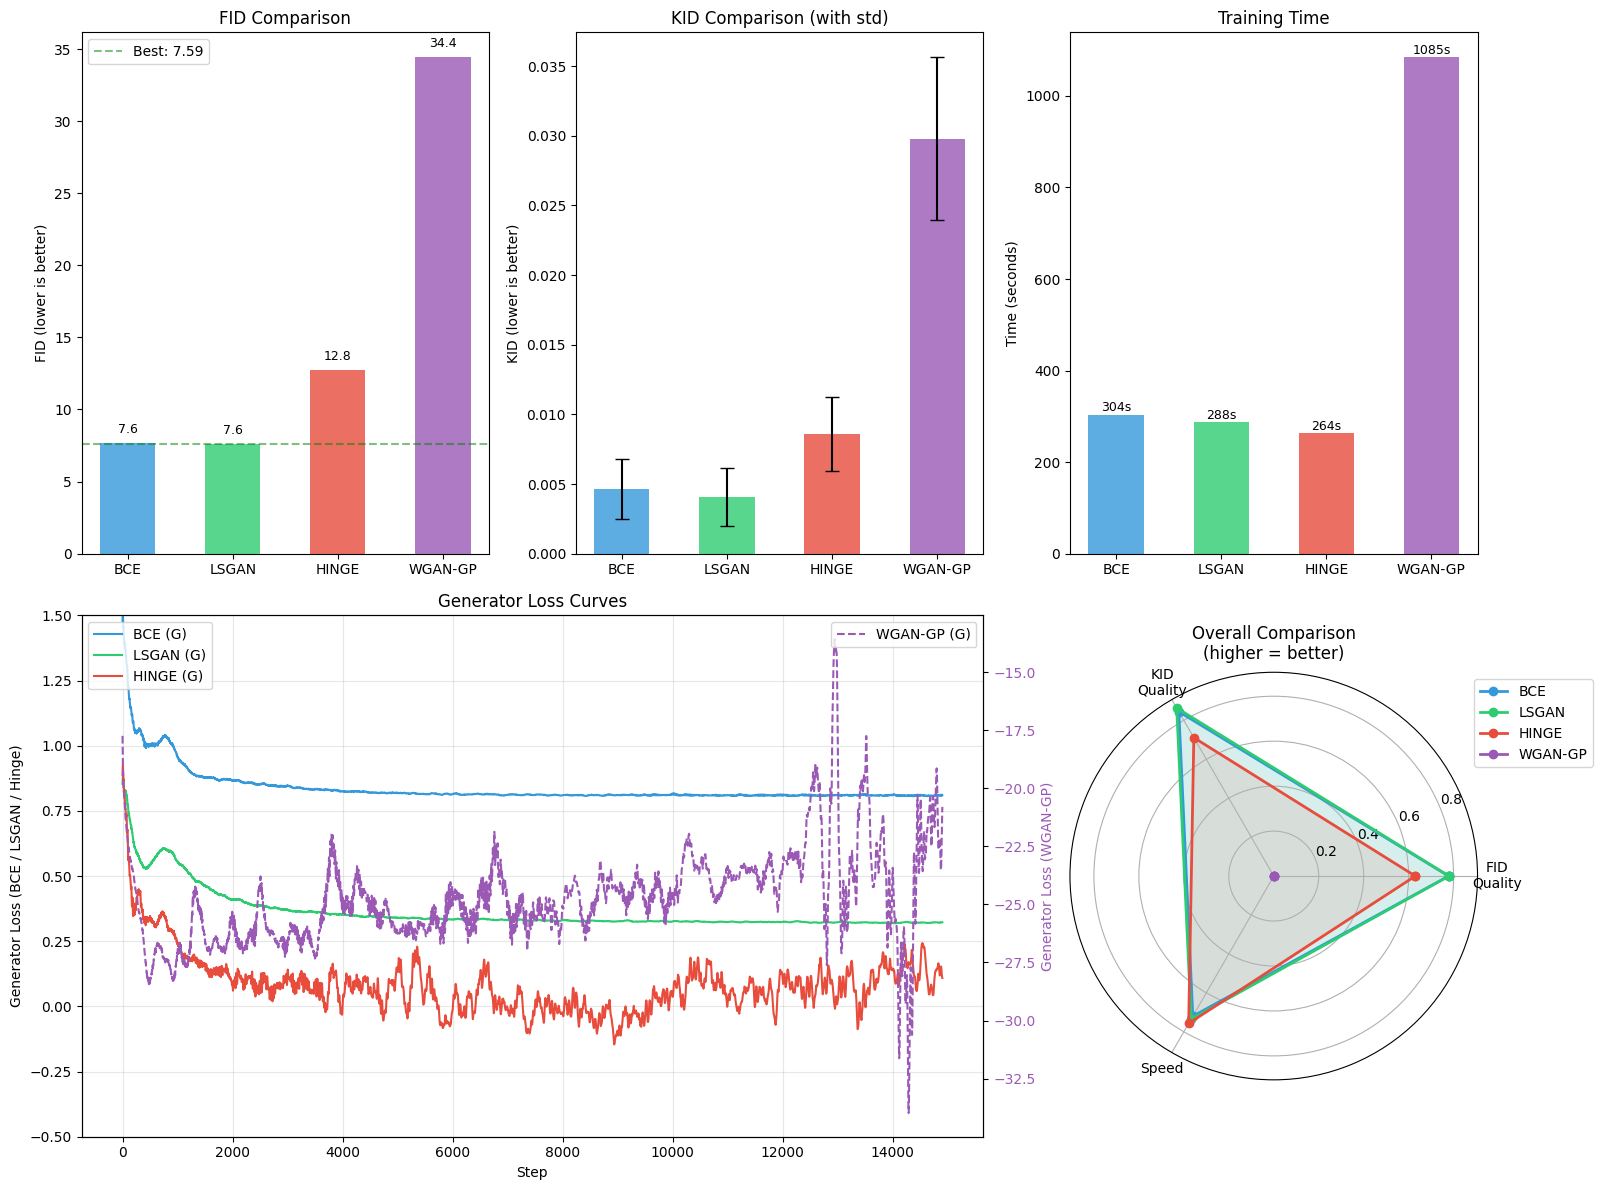

Saved: images/benchmark_comparison.png


In [14]:
# Comparison visualization

def plot_benchmark_comparison(results):
    """Create comprehensive comparison visualizations."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    # Color scheme
    colors = {'bce': '#3498db', 'lsgan': '#2ecc71', 'hinge': '#e74c3c', 'wgan-gp': '#9b59b6'}
    
    fig = plt.figure(figsize=(16, 12))
    
    # --- 1. FID Bar Chart (top left) ---
    ax1 = fig.add_subplot(2, 3, 1)
    x = np.arange(n_strategies)
    width = 0.35
    
    fids = [results[s]['fid'] for s in strategies]
    
    bars1 = ax1.bar(x, fids, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax1.set_ylabel('FID (lower is better)')
    ax1.set_title('FID Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.upper() for s in strategies])
    ax1.axhline(y=min(fids), color='green', linestyle='--', alpha=0.5, label=f'Best: {min(fids):.2f}')
    ax1.legend()
    
    for bar, val in zip(bars1, fids):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # --- 2. KID Bar Chart (top middle) ---
    ax2 = fig.add_subplot(2, 3, 2)
    kid_means = [results[s]['kid_mean'] for s in strategies]
    kid_stds = [results[s]['kid_std'] for s in strategies]
    
    bars2 = ax2.bar(x, kid_means, width*1.5, yerr=kid_stds, capsize=5,
                    color=[colors[s] for s in strategies], alpha=0.8)
    ax2.set_ylabel('KID (lower is better)')
    ax2.set_title('KID Comparison (with std)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.upper() for s in strategies])
    
    # --- 3. Training Time (top right) ---
    ax3 = fig.add_subplot(2, 3, 3)
    times = [results[s]['training_time'] for s in strategies]
    bars3 = ax3.bar(x, times, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax3.set_ylabel('Time (seconds)')
    ax3.set_title('Training Time')
    ax3.set_xticks(x)
    ax3.set_xticklabels([s.upper() for s in strategies])
    
    for bar, val in zip(bars3, times):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.0f}s', ha='center', va='bottom', fontsize=9)
    
    # --- 4. Loss Curves with Dual Y-Axis (bottom left, spans 2 columns) ---
    ax4 = fig.add_subplot(2, 3, (4, 5))
    
    # Smoothing function
    def smooth(data, window=100):
        if len(data) > window:
            return np.convolve(data, np.ones(window)/window, mode='valid')
        return data
    
    # Plot BCE, LSGAN, Hinge on left axis
    for s in ['bce', 'lsgan', 'hinge']:
        if s in results:
            losses_g = results[s]['losses']['G']
            smoothed = smooth(losses_g)
            ax4.plot(smoothed, label=f'{s.upper()} (G)', color=colors[s], linewidth=1.5)
    
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Generator Loss (BCE / LSGAN / Hinge)')
    ax4.set_ylim(-0.5, 1.5)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_title('Generator Loss Curves')
    
    # Plot WGAN-GP on right axis
    if 'wgan-gp' in results:
        ax4_right = ax4.twinx()
        losses_g = results['wgan-gp']['losses']['G']
        smoothed = smooth(losses_g)
        ax4_right.plot(smoothed, label='WGAN-GP (G)', color=colors['wgan-gp'], 
                       linewidth=1.5, linestyle='--')
        ax4_right.set_ylabel('Generator Loss (WGAN-GP)', color=colors['wgan-gp'])
        ax4_right.tick_params(axis='y', labelcolor=colors['wgan-gp'])
        ax4_right.legend(loc='upper right')
    
    # --- 5. Radar/Spider Chart (bottom right) ---
    ax5 = fig.add_subplot(2, 3, 6, projection='polar')
    
    max_fid = max(fids)
    max_kid = max(kid_means)
    max_time = max(times)
    
    metrics = ['FID\nQuality', 'KID\nQuality', 'Speed']
    n_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]
    
    for s in strategies:
        values = [
            1 - results[s]['fid'] / max_fid,
            1 - results[s]['kid_mean'] / max_kid,
            1 - results[s]['training_time'] / max_time,
        ]
        values += values[:1]
        ax5.plot(angles, values, 'o-', linewidth=2, label=s.upper(), color=colors[s])
        ax5.fill(angles, values, alpha=0.1, color=colors[s])
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_title('Overall Comparison\n(higher = better)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/benchmark_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/benchmark_comparison.png")

plot_benchmark_comparison(benchmark_results)

In [15]:
# Per-class quality analysis

def analyze_per_class_quality(results, n_samples=100):
    """
    Generate samples for each class and compute per-class statistics.
    Helps identify if certain digits are harder to generate.
    """
    print("\nPer-Class Analysis")
    print("="*60)
    
    class_stats = {s: {} for s in results.keys()}
    
    for strategy in results.keys():
        # Load the trained generator
        g_model = Generator().to(device)
        g_model.load_state_dict(results[strategy]['g_model_state'])
        g_model.eval()
        
        for digit in range(10):
            noise = torch.randn(n_samples, LATENT_DIM, device=device)
            labels = torch.full((n_samples, 1), digit, device=device)
            
            with torch.no_grad():
                samples = g_model(noise, labels)
            
            # Compute statistics
            mean_intensity = samples.mean().item()
            std_intensity = samples.std().item()
            
            class_stats[strategy][digit] = {
                'mean': mean_intensity,
                'std': std_intensity,
            }
    
    # Print comparison table
    print(f"\n{'Digit':<8}", end="")
    for s in results.keys():
        print(f"{s.upper():>12}", end="")
    print()
    print("-" * (8 + 12 * len(results)))
    
    for digit in range(10):
        print(f"{digit:<8}", end="")
        for s in results.keys():
            std = class_stats[s][digit]['std']
            print(f"{std:>12.3f}", end="")
        print()
    
    print("\n(Values show standard deviation - higher = more variety)")

analyze_per_class_quality(benchmark_results)


Per-Class Analysis

Digit            BCE       LSGAN       HINGE     WGAN-GP
--------------------------------------------------------
0              0.699       0.685       0.730       0.740
1              0.493       0.457       0.499       0.487
2              0.663       0.646       0.697       0.697
3              0.638       0.630       0.664       0.655
4              0.601       0.595       0.624       0.603
5              0.605       0.600       0.629       0.645
6              0.622       0.619       0.667       0.666
7              0.592       0.575       0.616       0.621
8              0.640       0.636       0.673       0.691
9              0.587       0.604       0.628       0.619

(Values show standard deviation - higher = more variety)


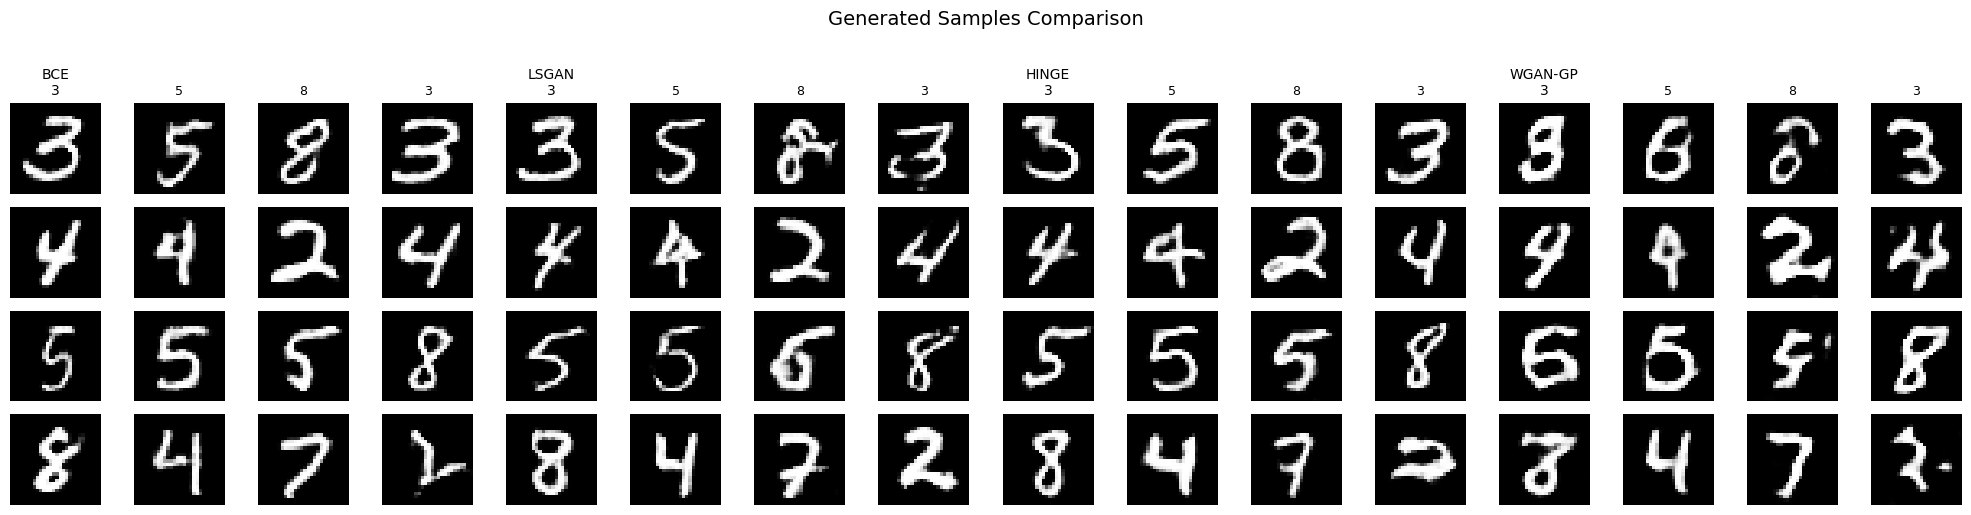

Saved: images/samples_comparison.png


In [16]:
# Generated Samples Comparison Grid

def plot_samples_comparison(results):
    """Show final generated samples from each strategy side by side."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    fig, axes = plt.subplots(4, n_strategies * 4, figsize=(n_strategies * 5, 5))
    
    for col, strategy in enumerate(strategies):
        samples = results[strategy]['final_samples']
        labels = results[strategy]['labels_test']
        
        for i in range(16):
            row = i // 4
            sub_col = i % 4
            ax = axes[row, col * 4 + sub_col]
            
            img = samples[i].numpy().reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Add strategy name as title for first row
            if i == 0:
                ax.set_title(f'{strategy.upper()}\n{labels[i].item()}', fontsize=10)
            elif row == 0:
                ax.set_title(str(labels[i].item()), fontsize=9)
    
    fig.suptitle('Generated Samples Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/samples_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/samples_comparison.png")

plot_samples_comparison(benchmark_results)

In [17]:
# Optional: Export benchmark results to CSV

def export_results_csv(results, filename='benchmark_results.csv'):
    """Export benchmark results to CSV for further analysis."""
    import csv
    
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Strategy', 'FID', 'KID_Mean', 'KID_Std', 'Training_Time_Seconds'])
        
        for name, data in results.items():
            writer.writerow([
                name,
                f"{data['fid']:.4f}",
                f"{data['kid_mean']:.6f}",
                f"{data['kid_std']:.6f}",
                f"{data['training_time']:.2f}"
            ])
    
    print(f"Results exported to {filename}")

# export_results_csv(benchmark_results)

# 8. Per-class Grid

---

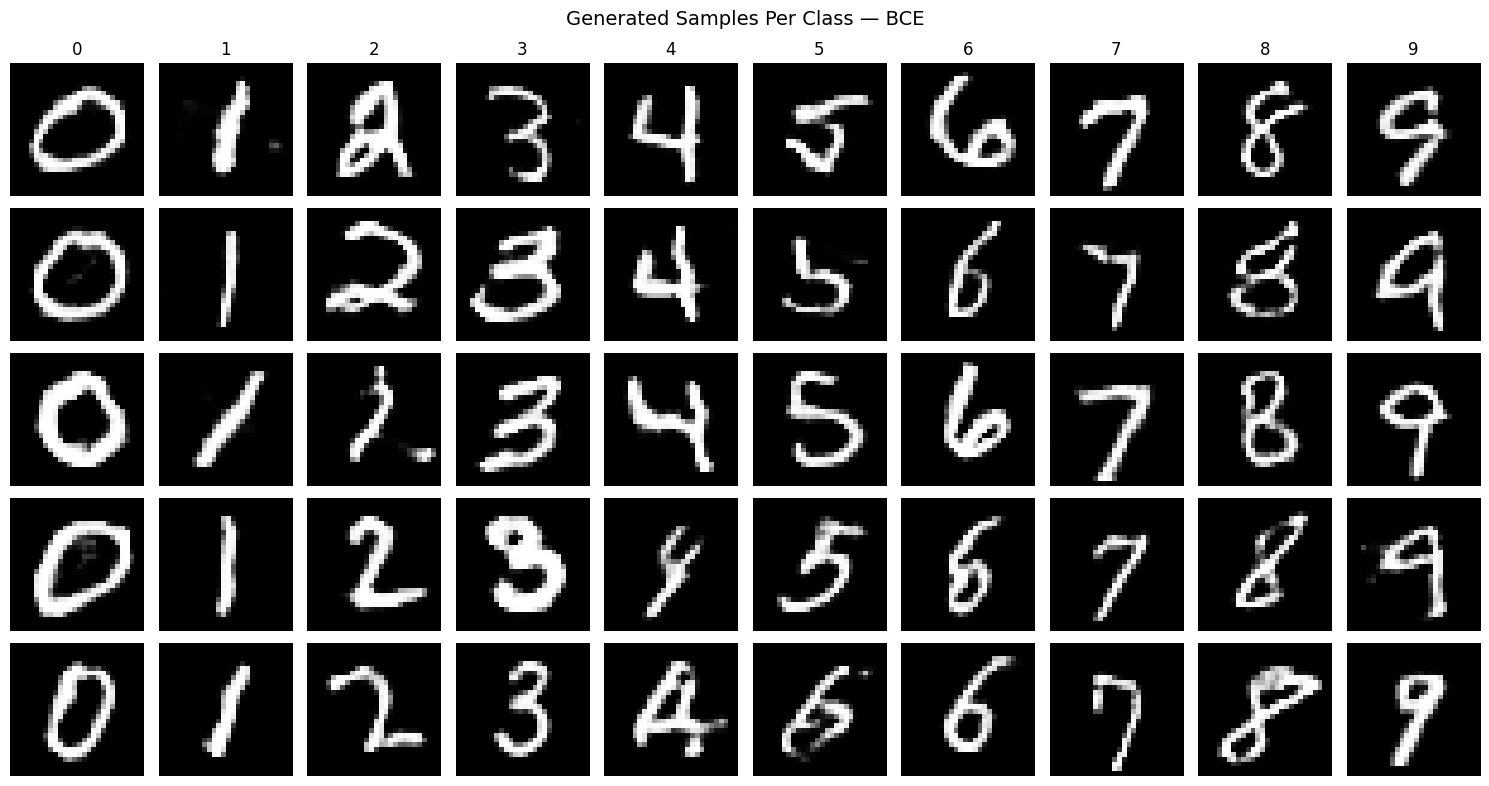

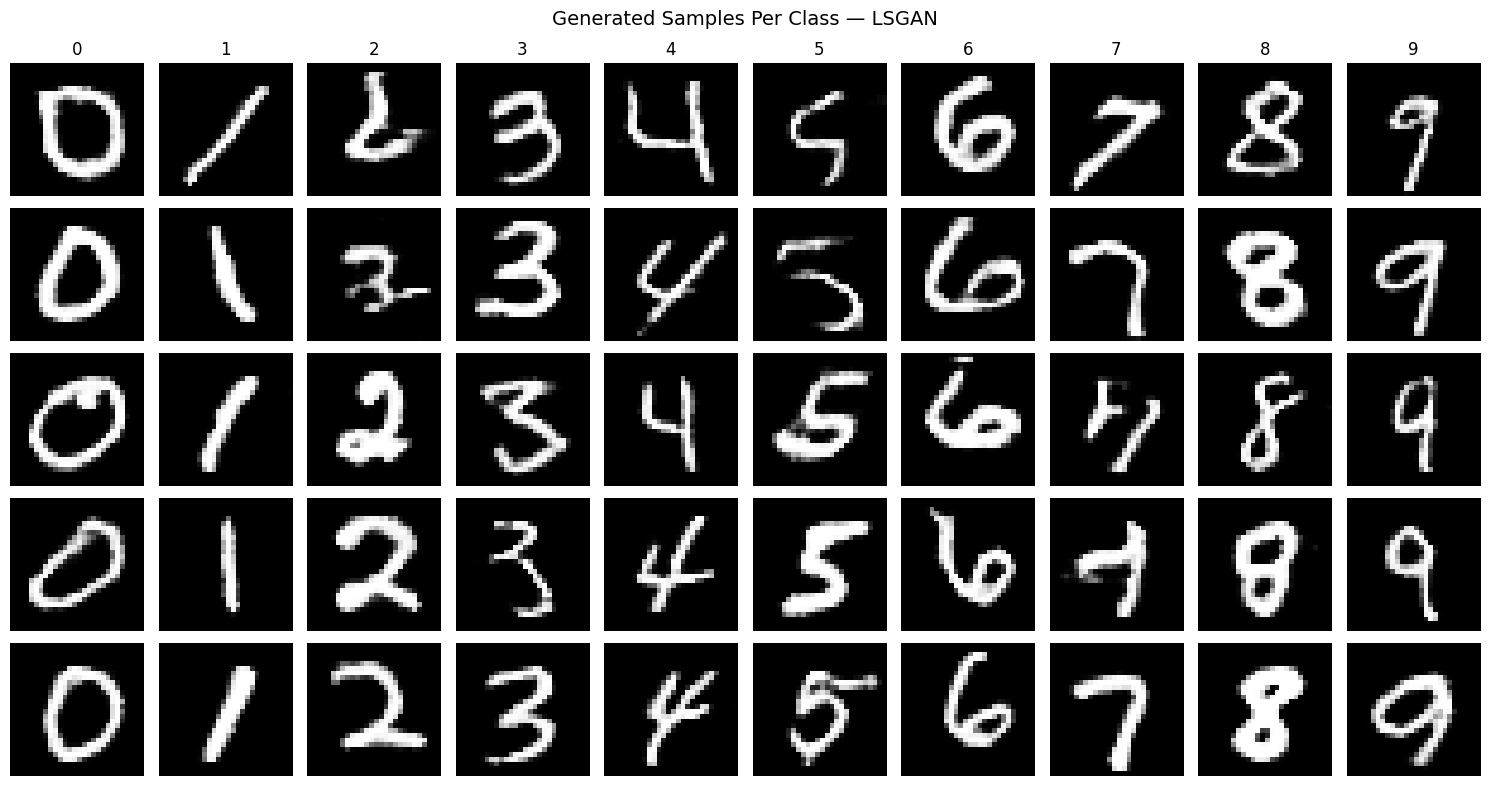

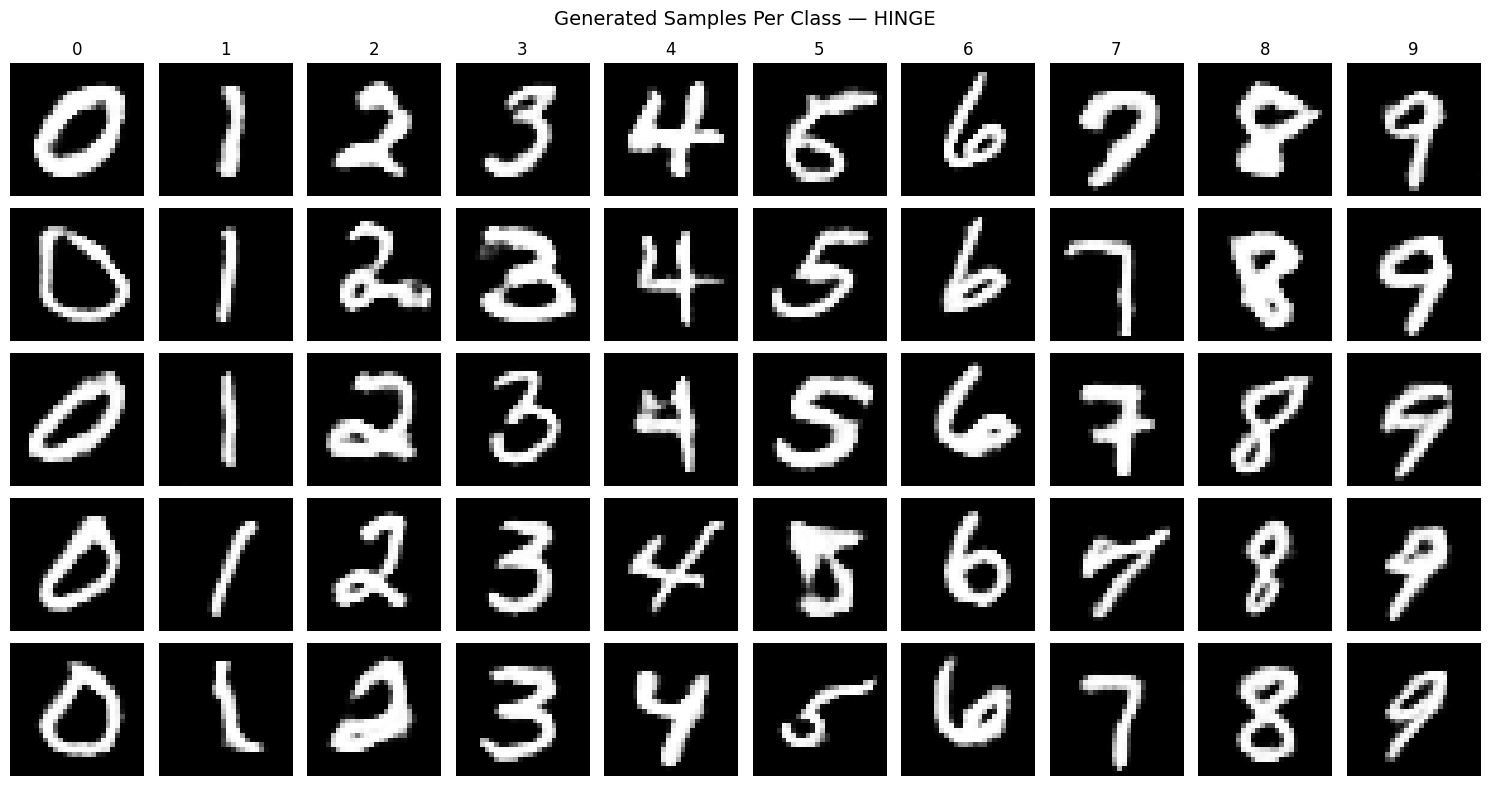

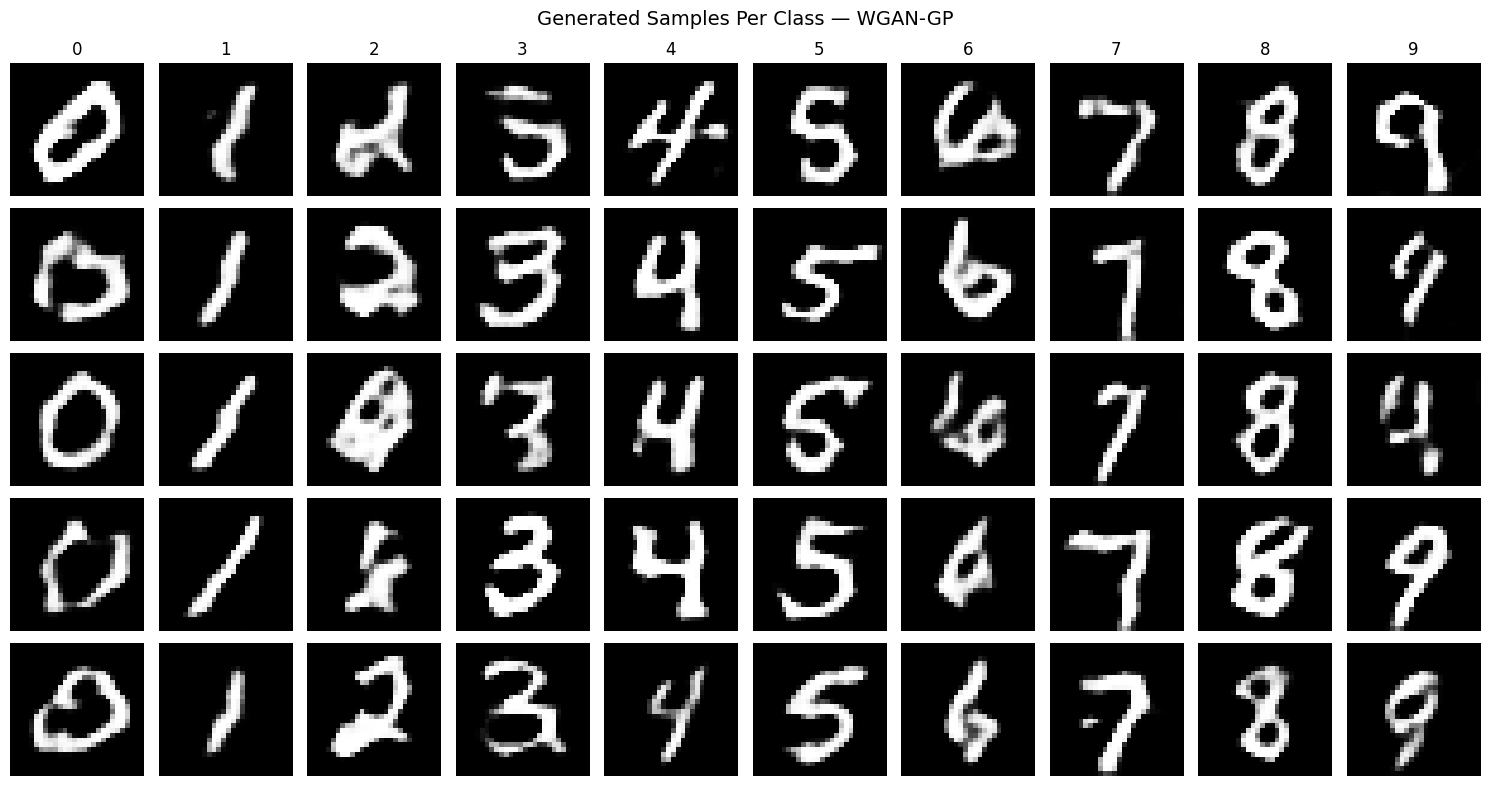

In [18]:
def plot_per_class(g_model, rows_per_class=5, title="Generated Samples Per Class"):
    """Generates a grid with one column per digit class (0-9)."""
    fig, axes = plt.subplots(rows_per_class, 10, figsize=(15, 8))

    for digit in range(10):
        noise = torch.randn(rows_per_class, LATENT_DIM, device=device)
        labels = torch.full((rows_per_class, 1), digit, device=device)

        with torch.no_grad():
            images = g_model(noise, labels)

        for row in range(rows_per_class):
            img = images[row].cpu().numpy().reshape(28, 28)
            axes[row, digit].imshow(img, cmap='gray')
            axes[row, digit].axis('off')

            if row == 0:
                axes[row, digit].set_title(str(digit))

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_per_class(g_model, title=f"Generated Samples Per Class — {strategy_name.upper()}")

# 10. Model Saving

---

In [19]:
def save_models(results):
    """Saves generator and discriminator state dicts for all strategies."""
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    
    for strategy_name, data in results.items():
        g_path = os.path.join(MODEL_OUTPUT_PATH, f'G_{strategy_name}.pt')
        d_path = os.path.join(MODEL_OUTPUT_PATH, f'D_{strategy_name}.pt')
        
        torch.save(data['g_model_state'], g_path)
        torch.save(data['d_model_state'], d_path)
        
        print(f"Saved: {g_path}, {d_path}")

save_models(benchmark_results)

Saved: model/G_bce.pt, model/D_bce.pt
Saved: model/G_lsgan.pt, model/D_lsgan.pt
Saved: model/G_hinge.pt, model/D_hinge.pt
Saved: model/G_wgan-gp.pt, model/D_wgan-gp.pt


# 11. Single-Image Inference

---

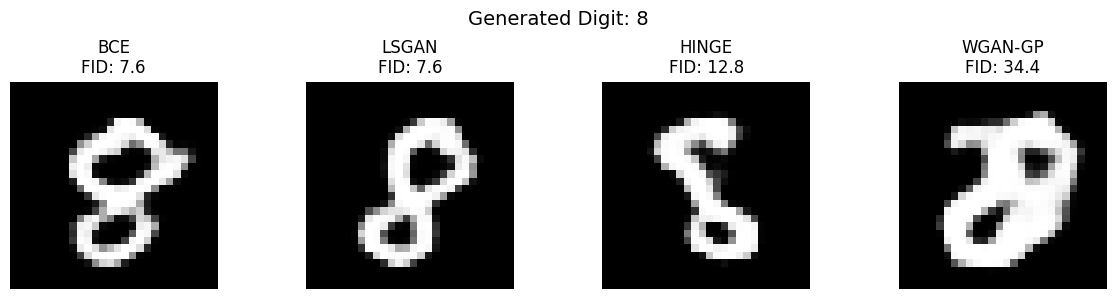

[gan_monitor] Client connected: Dc3n4hnXEIeE-4WUAAAD
[gan_monitor] Client disconnected: Dc3n4hnXEIeE-4WUAAAD


In [20]:
# Specify a digit from 0-9
digit = 8

# Use same noise for fair comparison
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([[digit]], device=device)

fig, axes = plt.subplots(1, len(benchmark_results), figsize=(3 * len(benchmark_results), 3))

for idx, (strategy_name, data) in enumerate(benchmark_results.items()):
    g_model = Generator().to(device)
    g_model.load_state_dict(data['g_model_state'])
    g_model.eval()
    
    with torch.no_grad():
        generated = g_model(z, label)
    
    img = generated[0].cpu().numpy().reshape(28, 28)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"{strategy_name.upper()}\nFID: {data['fid']:.1f}")
    axes[idx].axis('off')

fig.suptitle(f"Generated Digit: {digit}", fontsize=14)
plt.tight_layout()
plt.show()